## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [50]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [51]:
# read ab_data.csv
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [52]:
# count rows of the df
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [53]:
# count unique values
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [54]:
# count the proportion of users converted
count_conv = df.query('converted == "1"')['user_id'].nunique()
count_all = df['converted'].count()
count_conv/count_all


0.11944185983333221

e. The number of times the `new_page` and `treatment` don't line up.

In [55]:
# count the number of times the new_page and treatment don't line up 
df.query('group == "treatment" and landing_page != "new_page"')['landing_page'].count() + df.query('group != "treatment" and landing_page == "new_page"')['landing_page'].count()


3893

f. Do any of the rows have missing values?

In [56]:
# missing values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [57]:
# create new dataframe df2
df2_1 = df.query('group == "treatment" and landing_page == "new_page"')
df2_2 = df.query('group == "control" and landing_page == "old_page"')
df2 = pd.concat([df2_1, df2_2])

In [58]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [59]:
# count number of unique users
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [60]:
# find a duplicated user
g=df2['user_id'].value_counts()
g.where(g>1).dropna()

773192    2.0
Name: user_id, dtype: float64

c. What is the row information for the repeat **user_id**? 

In [61]:
# show a duplicated user
df2.query('user_id == "773192"')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [62]:
# remove a duplicate
df2 = df2.drop([2893])

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [63]:
 df2.groupby('converted')['user_id'].count()[1] / df2['converted'].count()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [64]:
df2_contr = df2.query('group == "control"')
df2_contr.groupby('converted')['user_id'].count()[1] / df2_contr['converted'].count()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [65]:
# calculate probability
df2_treat = df2.query('group == "treatment"')
df2_treat.groupby('converted')['user_id'].count()[1] / df2_contr['converted'].count()

0.1188375070556328

d. What is the probability that an individual received the new page?

In [66]:
# calculate probability of a new page
df2.query('landing_page == "new_page"')['user_id'].nunique() / df2['landing_page'].count()

0.50006194422266881

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

The probablity users converted in both group are pretty similar (12.03% and  11.88%) and the probability of an individual converting regardless of the page they receive is 11.95%. Thus, we can say that there is no evidence that one page leads to more conversions.


<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$H_{0}$**: The new page is less effective or equal to the old page. 

**$H_{1}$**: The new page is better than the old page. 

or $H_{0}$ : $p_{new}$ - $p_{old}$ <= 0

$H_{1}$ : $p_{new}$ - $p_{old}$ > 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [67]:
# calculate convert rate for p new
p_new = df2.query('converted == 1')['user_id'].nunique() / df2['user_id'].nunique()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [68]:
# calculate convert rate
p_old = df2.query('converted == 1')['user_id'].nunique() / df2['user_id'].nunique()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [69]:
# compute the number of unique users who has new pag
n_new = df2.query('landing_page == "new_page"')['user_id'].nunique()
n_new

145310

d. What is $n_{old}$?

In [70]:
# compute the number of unique users who has new page
n_old = df2.query('landing_page == "old_page"')['user_id'].nunique()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [71]:
# simulate new transactions
new_page_converted = np.random.choice(2, size = 145310, p=[0.8805, 0.1195])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [72]:
# simulate new transactions
old_page_converted = np.random.choice(2, size = 145274, p=[0.8805, 0.1195])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [73]:
(new_page_converted.sum()/len(new_page_converted)) - (old_page_converted.sum()/len(old_page_converted))

-0.00068335606961997253

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [74]:
# simulate 10000 values and store in new a variable p_diffs
p_diffs = np.random.binomial(n_new, p_new, 10000)/n_new - np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs[0:10]

array([-0.00071802, -0.00127554,  0.00032132, -0.00144743, -0.00070398,
        0.00081662,  0.00273034,  0.00180119, -0.00129608, -0.00090372])

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

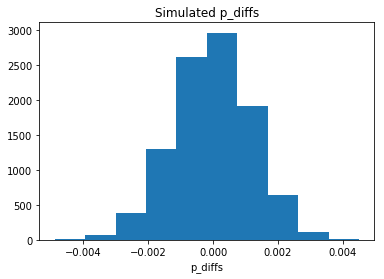

In [75]:
# plot a histogram
plt.hist(p_diffs)
plt.xlabel('p_diffs')
plt.title('Simulated p_diffs');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [76]:
# calculate proportion 
actual_diff = (df2[df2['group'] == "treatment"]['converted'].mean()) - (df2[df2['group'] == "control"]['converted'].mean())
p_diffs = np.array(p_diffs)
(p_diffs > actual_diff).mean()


0.90290000000000004

k. In words, explain what you just computed in part **j**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

The actual difference represents the difference between converted rates of the new page and converted rates of the old page for the data. The p-diffs represent the simulated difference between converted rates of new page and old page, based on 10000 simulated samples.
The 90.54% is called scientifically p-value, it determines the probability of obtaining our observed statistic if the null hypothesis is true.


l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [77]:
# calculate the number of conversions for each page and the number of individuals who received each page
import statsmodels.api as sm

convert_old = sum(df2.query('group == "control"')['converted'])
convert_new = sum(df2.query('group == "treatment"')['converted'])
n_old = df2.query("group == 'control'")['user_id'].count()
n_new = df2.query("group == 'treatment'")['user_id'].count()

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [78]:
# compute test statistic and p-value
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
print('z_score:',z_score)
print('p_value:', p_value)


z_score: -1.31092419842
p_value: 0.905058312759


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The negative z-score and the value of p-value suggests that we should fail to reject the null hypothesis. These values agree with the findings in parts j. and k.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

I should use logistic regression.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [79]:
# create a new column and dummy variable column
df2['intercept'] = 1
df2[['ab_page', 'old_page']] = pd.get_dummies(df['landing_page'])
df2 = df2.drop('old_page', axis = 1)
df2.head()


,user_id,timestamp,group,landing_page,converted,intercept,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [80]:
# Instantiate the model, and fit the model using the columns intercept and ab_page
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [81]:
# provide summary
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 19 Mar 2019   Pseudo R-squ.:               8.077e-06
Time:                        20:44:32   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

The p-value associated with ab_page column is 0.19. It is lower than the p-value calculated using the z-score function. The reason why is different is due to the intercept added 

The logistic regression determines only 2 possible outcomes - the new page is equal to the old page or not. Therefore, the null and alternative hypotheses associated with the regression model:

$H_{0}$ : $p_{new}$ - $p_{old}$ = 0

$H_{1}$ : $p_{new}$ - $p_{old}$ != 0

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Many other factors might influence whether or not an individual converts. We should add a factor to our regression model to understand the factor was influenced on converts or not. For example, we can consider timestamps to understand how the time of day effects on converting.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [82]:
#read and merge the countries.csv dataset 
countries_df = pd.read_csv('countries.csv')
df3 = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df3.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [83]:
# create dummy variable
df3[['CA', 'UK', 'US']] = pd.get_dummies(df3['country'])
df3 = df3.drop('US', axis = 1)
df3.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1


In [84]:
df3['intercept'] = 1
logit_mod = sm.Logit(df3['converted'], df3[['intercept', 'CA','UK',]])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Tue, 19 Mar 2019   Pseudo R-squ.:               1.521e-05
Time:                        20:44:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

As we can see above, the countries did not have significant effect on conversion rate.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [85]:

df3['intercept'] = 1
logit_mod = sm.Logit(df3['converted'], df3[['CA','UK','intercept', 'ab_page']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 19 Mar 2019   Pseudo R-squ.:               2.323e-05
Time:                        20:44:34   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
==============================================================================
"""

From the regression above we see that the p-value is higher in the UK than in Canada, it means that users in the UK are more likely to convert than in Canada. However, p-values related to country and the page are greater than 0.05, and I can conclude that countries did not have a significant effect on the conversion rate.

According to the performed analysis, I found that the old page was better than the new page. Therefore I fail to reject the null hypothesis.

In [86]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0